# Problem Statement


## Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## Understanding the Business Objective and the Data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Understanding Customer Behaviour During Churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

# Imports & Data Loading

In [10]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [11]:
# Read the data
cust = pd.read_csv("data/telecom_churn_data.csv")

In [12]:
cust.shape

(99999, 226)

In [13]:
cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [14]:
# Smaller file to check on the first 10 records in the dataset
cust.head(10).T.to_csv("sample_10_T.csv")

In [15]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


# Utility Methods

## Check for missing values in a dataframe

In [16]:
# Check for missing values in the dataframe and print them
def print_missing_columns(input_df):
    # Print missing percentage of only columns with missing values
    missing_columns = input_df.columns[input_df.isnull().any()]
    if not missing_columns.empty:
        missing_count = input_df[missing_columns].isnull().sum()
        missing_col_type = pd.Series([type(col) for col in input_df[missing_columns]],index = missing_columns) 
        unique_count = input_df[missing_columns].nunique()

        missing_df = pd.concat({
                        "Missing": missing_count, 
                        "Missing %": missing_count/len(input_df.index)*100,
                        "Type": missing_col_type,
                        "Unique Count": unique_count
                       } , 
                       axis = 1).sort_values(by = 'Missing', ascending = False)

        display(missing_df)
    else:
        display("NO MISSING VALUES IN THE DATAFRAME")

# Data Preprocessing

## Check for missing data

In [17]:
print_missing_columns(cust)

,Missing,Missing %,Type,Unique Count
count_rech_2g_6,74846,74.846748,<class 'str'>,31
max_rech_data_6,74846,74.846748,<class 'str'>,48
arpu_3g_6,74846,74.846748,<class 'str'>,7418
av_rech_amt_data_6,74846,74.846748,<class 'str'>,887
count_rech_3g_6,74846,74.846748,<class 'str'>,25
night_pck_user_6,74846,74.846748,<class 'str'>,2
arpu_2g_6,74846,74.846748,<class 'str'>,6990
fb_user_6,74846,74.846748,<class 'str'>,2
total_rech_data_6,74846,74.846748,<class 'str'>,37
date_of_last_rech_data_6,74846,74.846748,<class 'str'>,30


## Handle missing data

### Replace missing with 0
Missing 'incoming' & 'outgoing' call related columns can be set to 0 assuming there were no calls received/made for that column type

In [18]:
cust.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [19]:
# Incoming calls column:
# All columns with incoming call information have the string "ic_" in the column name
# Fill the missing values in these columns with 0
incoming_cols = [col for col in cust.columns if 'ic_' in col]
cust[incoming_cols] = cust[incoming_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(incoming_cols)} incoming columns:{incoming_cols}')

# Outgoing calls column:
# All columns with outgoing call information have the string "og_" in the column name
# Fill the missing values in these columns with 0
outcoming_cols = [col for col in cust.columns if 'og_' in col]
cust[outcoming_cols] = cust[outcoming_cols].fillna(0)
print(f'\nReplaced missing values with 0 for {len(outcoming_cols)} outgoing columns:{outcoming_cols}')

Replaced missing values with 0 for 57 incoming columns:['loc_ic_t2o_mou', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'std_ic_mou_9', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_ic_mou_9', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'spl_ic_mou_9', 'isd_ic_mou_6', 'isd_ic_mou_7', 'i

In [20]:
# Recharge related columns
rech_cols = [col for col in cust.columns if re.match('^count_rech_|^max_rech_|^total_rech_|^av_rech_', col)]
cust[rech_cols] = cust[rech_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(rech_cols)} recharge columns :{rech_cols}')

Replaced missing values with 0 for 32 recharge columns :['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


In [21]:
# OFFNET/ONNET MOU related columns
mou_cols = [col for col in cust.columns if re.match('^onnet_mou|^offnet_mou', col)]
cust[mou_cols] = cust[mou_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(mou_cols)} OFFNET/ONNET MOU columns :{mou_cols}')

Replaced missing values with 0 for 8 OFFNET/ONNET MOU columns :['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9']


In [22]:
# arpu related columns
arpu_cols = [col for col in cust.columns if re.match('^arpu', col)]
cust[arpu_cols] = cust[arpu_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(arpu_cols)} arpu columns :{arpu_cols}')

Replaced missing values with 0 for 12 arpu columns :['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9']


### Handle date columns

In [23]:
print(f'Shape before handling date columns:{cust.shape}')

Shape before handling date columns:(99999, 226)


In [24]:
# Change data type of date columns to datetime
date_cols = [col for col in cust.columns if re.match('^date|^last_date', col)]
cust[date_cols] = cust[date_cols].apply(pd.to_datetime) 

In [25]:
# For each month, convert the recharge date to number of days before the last date.
# Fill missing values with no. of days in the month
month_suffixes = [6,7,8,9]
for month in month_suffixes:
    last_date_month = f'last_date_of_month_{month}'
    date_last_rech = f'date_of_last_rech_{month}'
    date_last_rech_data = f'date_of_last_rech_data_{month}'
    last_rech_days = f'last_rech_days_{month}'
    max_days_month = 30 if month in [6,9] else 31
    
    # Create the columns for days since any recharge has been done from the last date of the month
    # Eg: if last_rech_days = 2, user has recharged 2 days before the last day of the month
    cust[last_rech_days] = (cust[last_date_month] - cust[[date_last_rech,date_last_rech_data]].max(axis=1)).dt.days

    # Fill missing values with maximum days possible for the month
    cust[last_rech_days]=cust[last_rech_days].fillna(max_days_month)


In [26]:
# drop date columns after creating the days columns
print(f'Shape before dropping date columns:{cust.shape}')
cust.drop(date_cols,inplace=True,axis=1)
print(f'Shape after dropping date columns:{cust.shape}')

Shape before dropping date columns:(99999, 230)
Shape after dropping date columns:(99999, 218)


In [27]:
print_missing_columns(cust)

,Missing,Missing %,Type,Unique Count
night_pck_user_6,74846,74.846748,<class 'str'>,2
fb_user_6,74846,74.846748,<class 'str'>,2
night_pck_user_7,74428,74.428744,<class 'str'>,2
fb_user_7,74428,74.428744,<class 'str'>,2
night_pck_user_9,74077,74.077741,<class 'str'>,2
fb_user_9,74077,74.077741,<class 'str'>,2
night_pck_user_8,73660,73.660737,<class 'str'>,2
fb_user_8,73660,73.660737,<class 'str'>,2


### IterativeImputer

In [28]:
# # Use fancy imputer to fill the rest of the missing colums (fb_user_* and night_pck_user_* columns)
# from fancyimpute import KNN
# knn_imputer = KNN()
# # imputing the missing value with knn imputer
# cust = knn_imputer.fit_transform(cust)
# Unable to install fancyimpute with pip install due to dependent version mismatches.

In [29]:
# Use iterative imputer to fill the rest of the missing colums (fb_user_* and night_pck_user_* columns)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iter_imputer = IterativeImputer()

fb_night_cols = [col for col in cust.columns if re.match('^fb_user_|^night_pck_user_', col)]

cust[fb_night_cols] = iter_imputer.fit_transform(cust[fb_night_cols])

/Users/le0080/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [30]:
print_missing_columns(cust)

'NO MISSING VALUES IN THE DATAFRAME'

## Check data types

In [31]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 218 entries, mobile_number to last_rech_days_9
dtypes: float64(183), int64(35)
memory usage: 166.3 MB


## Check for outliers

# Target Variable Creation

## Create Target variable from 9th Month

Create the target variable based on the below rule:
 
Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9,
total_og_mou_9,
vol_2g_mb_9,
vol_3g_mb_9

In [32]:
# Create churn flag based on the 9th month variables. 
cust['churn'] = (cust['total_ic_mou_9']+cust['total_og_mou_9']+cust['vol_2g_mb_9']+cust['vol_3g_mb_9']) == 0
cust['churn']=cust['churn'].map({True:1,False:0})

In [33]:
cust['churn'].value_counts()

0    89808
1    10191
Name: churn, dtype: int64

## Remove 9th month variables

In [34]:
# drop the columns with the suffix _9, they should not be used while training the model.

print(f'Shape before dropping 9th month columns:{cust.shape}')
month_9_cols = [col for col in cust.columns if re.search('_9$', col)]
cust.drop(month_9_cols,inplace=True,axis=1)
print(f'Shape after dropping 9th month columns:{cust.shape}')

Shape before dropping 9th month columns:(99999, 219)
Shape after dropping 9th month columns:(99999, 167)


Remove the 9th month variables after creating the target variables. Would otherwise lead to data leakage.

# Identify High Value Customers

We need to predict churn only for the high-value customers. <br>
Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

## Find average of M6,M7

In [ ]:
cust.head()

In [51]:
m6_cols = [col for col in cust.columns if re.search('.*rech.*_6$' , col)]
cust[m6_cols].head()


,total_rech_num_6,total_rech_amt_6,max_rech_amt_6,total_rech_data_6,max_rech_data_6,count_rech_2g_6,count_rech_3g_6,av_rech_amt_data_6,last_rech_days_6
0,4,362,252,1.0,252.0,0.0,1.0,252.0,9.0
1,4,74,44,0.0,0.0,0.0,0.0,0.0,1.0
2,5,168,86,0.0,0.0,0.0,0.0,0.0,13.0
3,10,230,60,0.0,0.0,0.0,0.0,0.0,2.0
4,5,196,56,1.0,56.0,1.0,0.0,56.0,4.0


In [49]:
# Check if total recharge data column is same as sum of no. of recharges in 2G & 3G
print(cust[cust['total_rech_data_6'] != (cust['count_rech_2g_6']+cust['count_rech_3g_6'])].empty)
print(cust[cust['total_rech_data_7'] != (cust['count_rech_2g_7']+cust['count_rech_3g_7'])].empty)

True
True


Assumption: total_rech_amt_* column is only for the talktime recharge and not for data recharge <br>
This information is not clear in the data dictionary and requires domain knowledge. <br>
We can compute the total rech amount for a month as sum of (talktime recharge + data recharge)

In [53]:
cust['avg_rech_amt_6_7'] = ((cust['total_rech_amt_6'] + cust['total_rech_data_6']*cust['av_rech_amt_data_6']) +
                            (cust['total_rech_amt_7'] + cust['total_rech_data_7']*cust['av_rech_amt_data_7']))/2

In [57]:
cust[['total_rech_amt_6','total_rech_data_6','av_rech_amt_data_6','total_rech_data_7','av_rech_amt_data_7','total_rech_amt_7','avg_rech_amt_6_7']].tail()

,total_rech_amt_6,total_rech_data_6,av_rech_amt_data_6,total_rech_data_7,av_rech_amt_data_7,total_rech_amt_7,avg_rech_amt_6_7
99994,60,0.0,0.0,0.0,0.0,110,85.0
99995,110,0.0,0.0,0.0,0.0,110,110.0
99996,119,2.0,39.0,0.0,0.0,0,98.5
99997,381,3.0,583.0,2.0,358.0,358,1602.0
99998,710,1.0,154.0,0.0,0.0,0,432.0


Manually computing the average recharge amount looks to be correct. <br>
We can now identify the value at the 70th percentile to identify the High Value Customers

## Identify value at 70th percentile

In [73]:
cust[['avg_rech_amt_6_7']].describe(percentiles=[0.1,0.3,0.5,0.7,0.9])

,avg_rech_amt_6_7
count,99999.000000
mean,485.328068
std,869.423594
min,0.000000
10%,60.000000
30%,155.000000
50%,275.000000
70%,478.000000
90%,1028.000000
max,61236.000000


In [72]:
avg_70 = cust[['avg_rech_amt_6_7']].quantile(0.7)[0]
print(f'Value at 70th percentile:{avg_70}')

Value at 70th percentile:478.0


## Flag high value customers

In [77]:
cust['is_hvc'] = cust['avg_rech_amt_6_7'].apply(lambda x: int(x>= avg_70))


In [78]:
cust['is_hvc'].value_counts()

0    69998
1    30001
Name: is_hvc, dtype: int64

In [79]:
cust.shape

(99999, 169)

# Define Variables

In [106]:
m8_toc_cols = ['loc_og_t2c_mou_8']
aon_cols = ['aon']
mou_cols = [col for col in cust.columns if re.search('^total_.*mou.*' , col)]

cols_to_analyse = m8_toc_cols+aon_cols+mou_cols
cols_to_analyse

['loc_og_t2c_mou_8',
 'aon',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8']

In [107]:
cust[cols_to_analyse].head()

,loc_og_t2c_mou_8,aon,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
0,0.00,968,0.00,0.00,0.00,0.00,0.00,5.44
1,0.00,1006,40.31,178.53,312.44,26.83,104.23,423.28
2,45.76,1103,155.33,412.94,285.46,370.04,519.53,395.03
3,0.00,2491,223.23,135.31,352.21,280.08,216.61,53.13
4,0.00,1526,127.28,241.33,208.16,216.44,198.29,338.81


In [108]:
DEPENDENT_VARIABLE = 'churn'
CONTINUOUS_VAR_TO_ANALYSE = cols_to_analyse

# EDA

## Target variable analysis

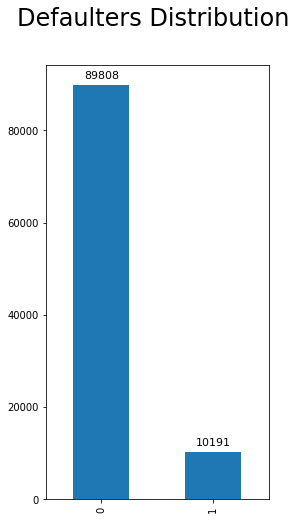

In [109]:
fig = plt.figure(figsize=(4,8))
fig.suptitle('Defaulters Distribution', fontsize=24)
ax = cust[DEPENDENT_VARIABLE].value_counts().plot.bar()
for p in ax.patches: 
    ax.annotate("%0.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11,  xytext=(0, 10), textcoords='offset points')


## Univariate analysis

### Continuous Features - Univariate & Segmented Univariate Analysis

/Users/le0080/.pyenv/versions/3.6.6/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


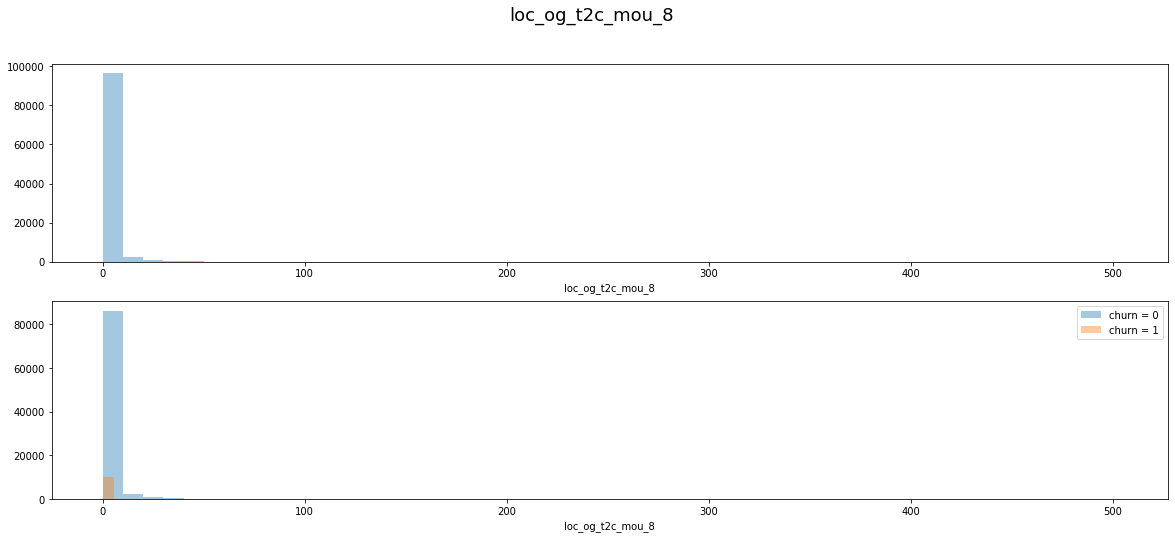

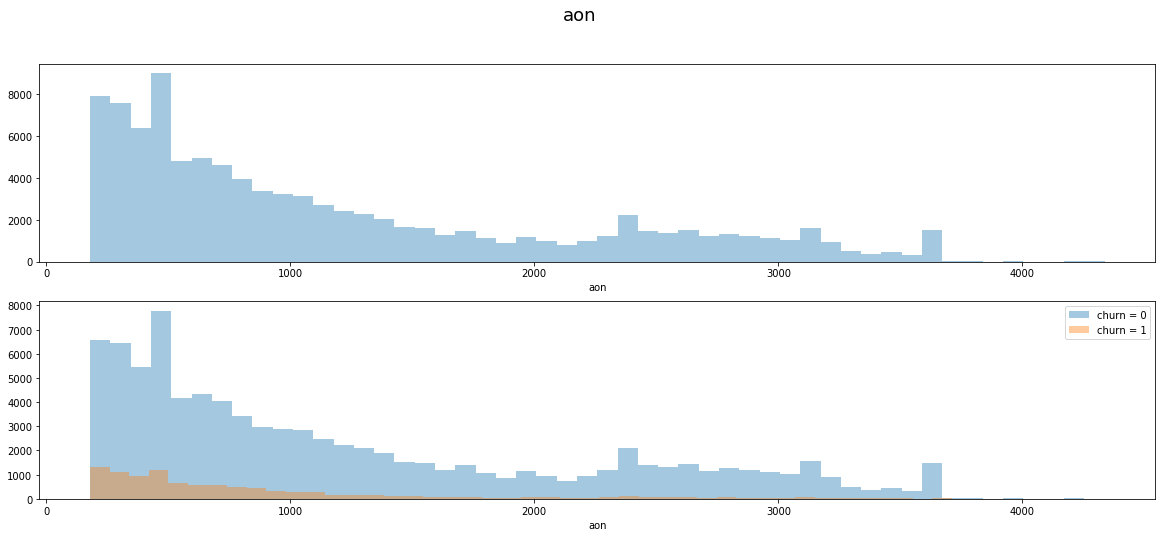

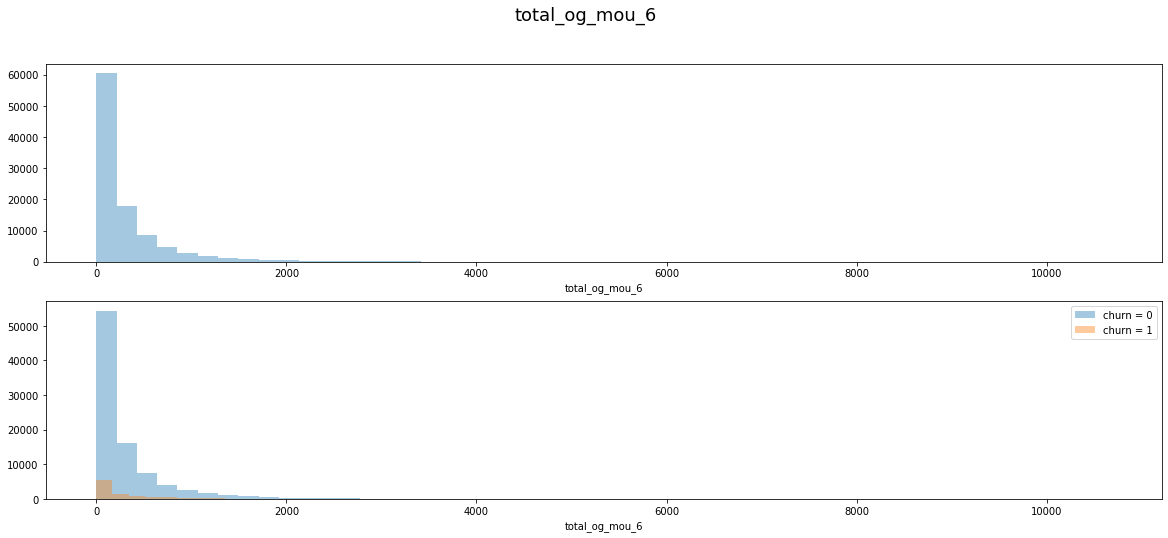

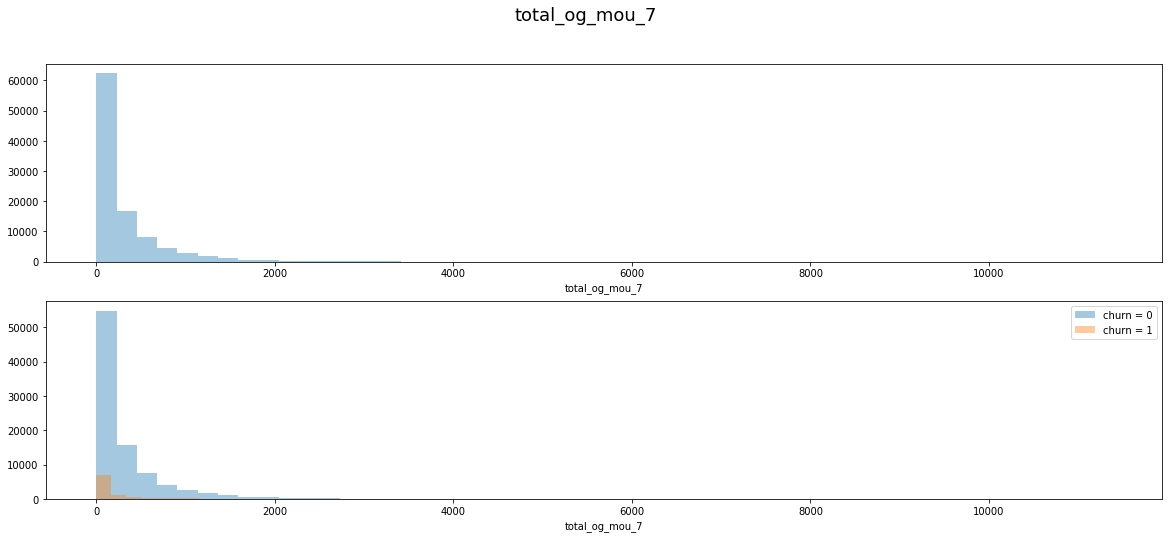

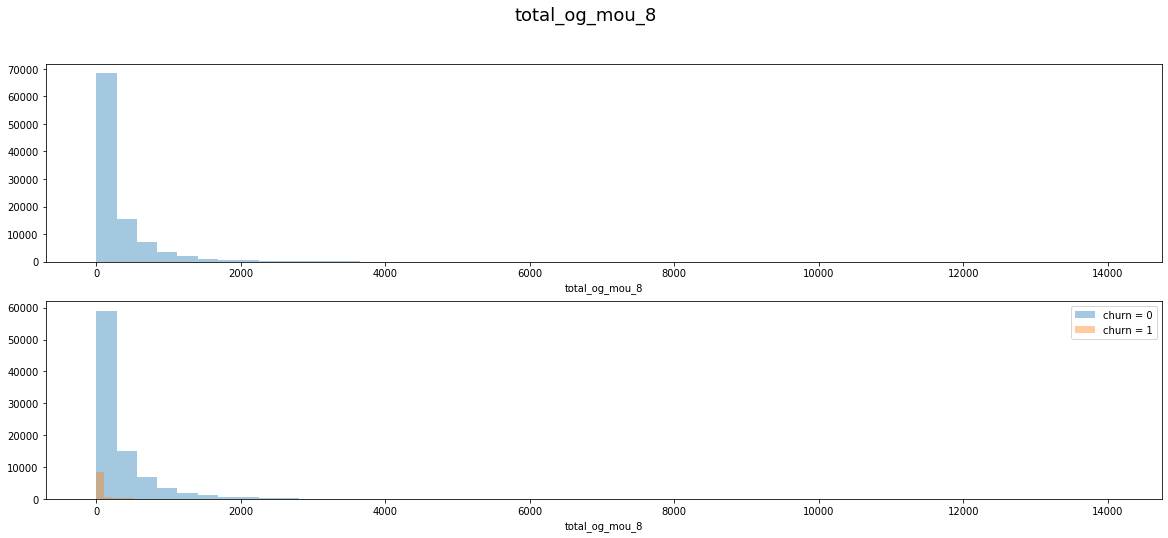

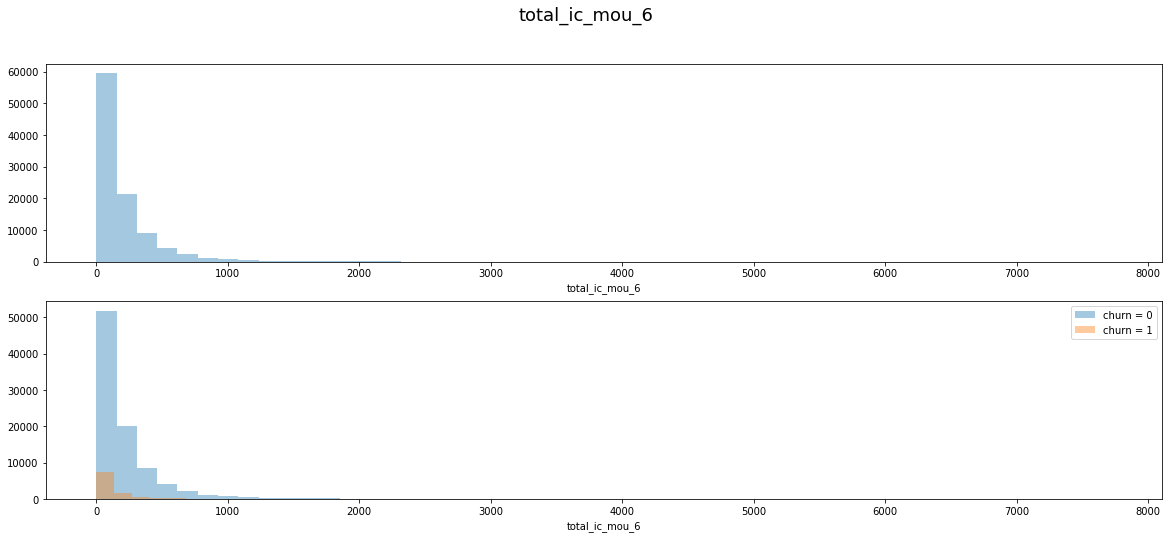

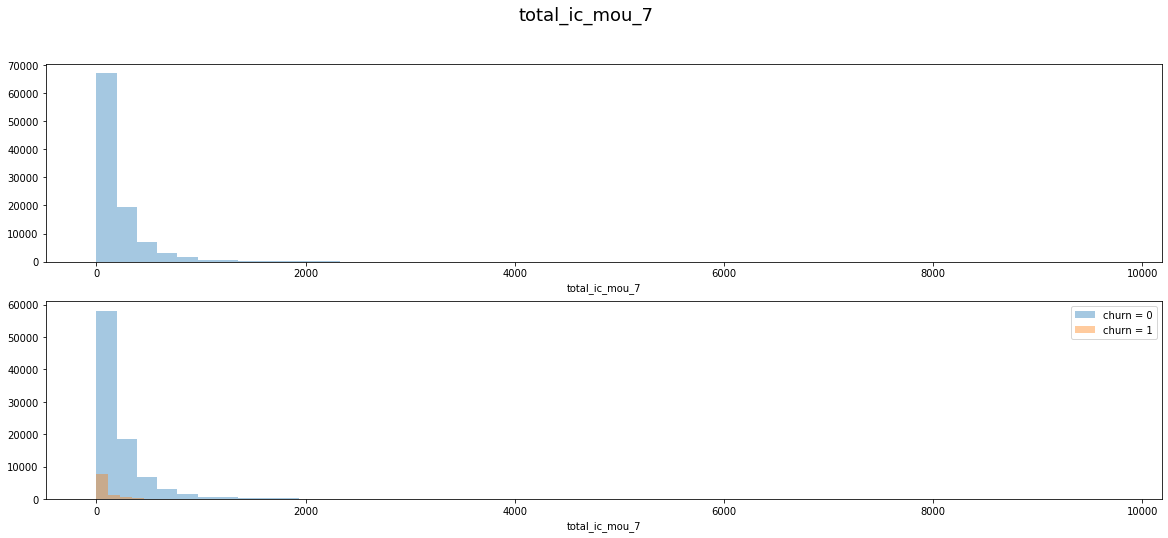

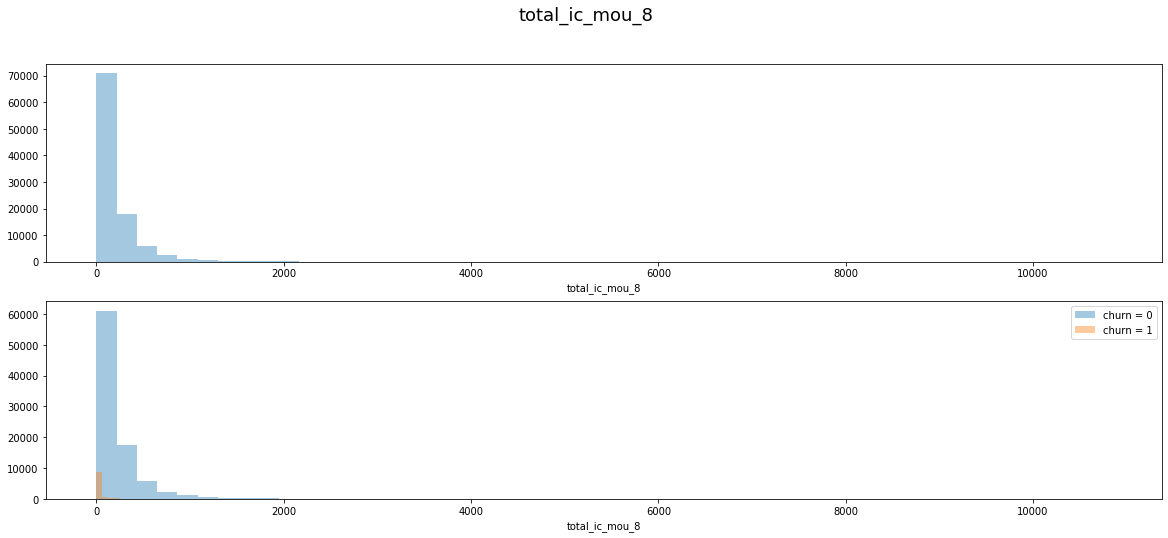

In [110]:

# For each continuous variable, plot
# a. Distribution plot for each continuous variable - Univariate Analysis
# b. Distribution plot against the target variable - Segmented Univariate Analysis
for col in CONTINUOUS_VAR_TO_ANALYSE:
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    fig.suptitle(col, fontsize=18)
    sns.distplot(cust[col], kde=False, ax=ax[0])
    for i in sorted(cust[DEPENDENT_VARIABLE].unique()):
        sns.distplot(cust[cust[DEPENDENT_VARIABLE] == i][col], kde=False, ax=ax[1], label=f'{DEPENDENT_VARIABLE} = {i}')
    ax[1].legend()

## Bivariate analysis

### Heat map/correlation matrix

In [118]:
df = cust[CONTINUOUS_VAR_TO_ANALYSE + ['churn']]
corr = df.corr() 

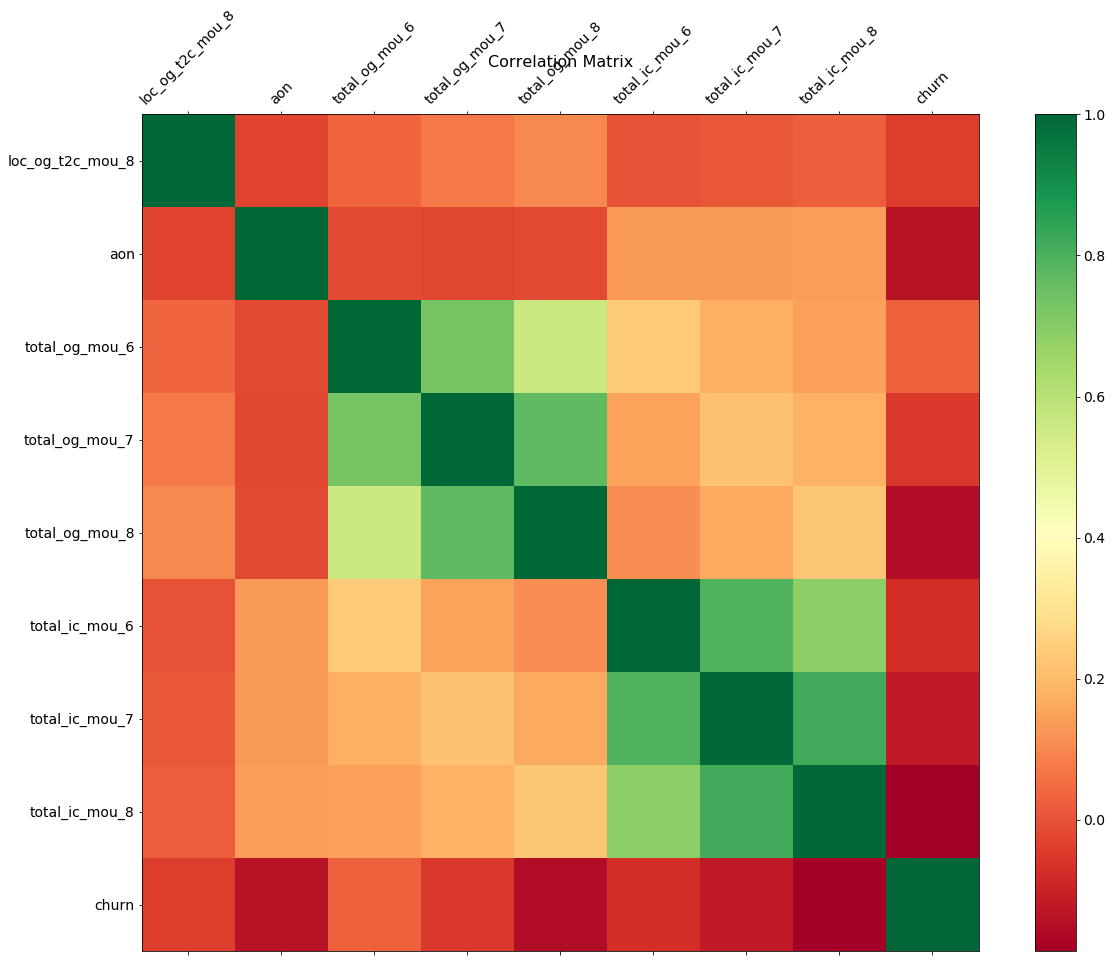

In [119]:
f = plt.figure(figsize=(20, 15))

ax = plt.matshow(corr, fignum=f.number,cmap='RdYlGn')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#ax.set_ylim([0,2])
plt.title('Correlation Matrix', fontsize=16);

In [120]:

corr.style.background_gradient(cmap='coolwarm').set_precision(1)

,loc_og_t2c_mou_8,aon,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,churn
loc_og_t2c_mou_8,1,-0.03,0.04,0.07,0.1,0.003,0.01,0.03,-0.04
aon,-0.03,1,-0.02,-0.02,-0.02,0.1,0.1,0.1,-0.1
total_og_mou_6,0.04,-0.02,1,0.7,0.6,0.2,0.2,0.1,0.03
total_og_mou_7,0.07,-0.02,0.7,1,0.8,0.1,0.2,0.2,-0.05
total_og_mou_8,0.1,-0.02,0.6,0.8,1,0.1,0.2,0.2,-0.2
total_ic_mou_6,0.003,0.1,0.2,0.1,0.1,1,0.8,0.7,-0.07
total_ic_mou_7,0.01,0.1,0.2,0.2,0.2,0.8,1,0.8,-0.1
total_ic_mou_8,0.03,0.1,0.1,0.2,0.2,0.7,0.8,1,-0.2
churn,-0.04,-0.1,0.03,-0.05,-0.2,-0.07,-0.1,-0.2,1


In [ ]:
sns.pairplot(df)

<TODO> Insights:
    High correlation between 2 consecutive months (M6 & M7, M7 & M8).<br>
    Good correlation between alternate months (M6 & M8)<br>
#     Churn is negatively correlated to the calls made to the customer care (t2c). More calls to customer care implies more chances of churning.

# Derive new features

## average usage - 3 months

## Good phase vs Action phase

# Handle class imbalance

## Oversampling

## SMOTE

# Train-test split

# Model building 1 - PCA

## PCA for dimensionality reduction

## Model building - PCA

### Default Model Building

1. 8 models? <br>
2. Evaluate on train & test data <br>
3. Fill metrics - Accuracy, Precision, Recall, F1-score, AUROC?

### Model building with HPT

### Model on oversampled data

### Model on SMOTE data

### Model on (SMOTE + HPT)

# Model building 2 - without PCA

# Insights

## Best Model - with PCA

Finally, choose a model based on some evaluation metric.

## Important features

After identifying important predictors, display them visually - you can use plots, summary tables etc. - whatever you think best conveys the importance of features.

## Conclusion - recommendation to manage customer churn

Finally, recommend strategies to manage customer churn based on your observations.